In [1]:
!pip install timm

In [2]:
import timm
import torch
import torch.nn as nn
import pandas as pd
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [3]:
# [코드 2] 장치 설정 (GPU 사용 가능 시 GPU를 사용하도록 설정)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

Using cuda device


In [4]:
# 데이터 경로 설정
dataset_path = "../_preprocessed_datasets_no_watermark"
categories = ["blue_jellyfish", "barrel_jellyfish", "compass_jellyfish", 
              "lions_mane_jellyfish", "mauve_stinger_jellyfish", "Moon_jellyfish"]

In [5]:
# 이미지 크기 및 하이퍼파라미터 설정
img_height, img_width = 224, 224
batch_size = 32

In [6]:
# 데이터셋 준비
def prepare_data(dataset_path, categories):
    filepaths, labels = [], []
    for label, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        if os.path.exists(category_path):
            for file in os.listdir(category_path):
                if file.endswith(('jpg', 'jpeg', 'png')):
                    filepaths.append(os.path.join(category_path, file))
                    labels.append(label)
    return filepaths, labels

filepaths, labels = prepare_data(dataset_path, categories)

In [7]:
# Train/Test 분리
train_files, test_files, train_labels, test_labels = train_test_split(
    filepaths, labels, test_size=0.2, stratify=labels, random_state=42
)

# Train/Validation 분리
train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)

In [8]:
# 숫자 라벨 -> 문자열 클래스 이름으로 변환
label_to_class = {idx: name for idx, name in enumerate(categories)}
train_labels = [label_to_class[label] for label in train_labels]
val_labels = [label_to_class[label] for label in val_labels]
test_labels = [label_to_class[label] for label in test_labels]

In [9]:
# DataFrame 생성
train_df = pd.DataFrame({'filename': train_files, 'class': train_labels})
val_df = pd.DataFrame({'filename': val_files, 'class': val_labels})
test_df = pd.DataFrame({'filename': test_files, 'class': test_labels})


In [10]:
# Custom Dataset class
class JellyfishDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['filename']
        image = Image.open(img_path).convert('RGB')
        label = categories.index(self.dataframe.iloc[idx]['class'])
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# Create Dataset objects
train_dataset = JellyfishDataset(train_df, transform=transform)
val_dataset = JellyfishDataset(val_df, transform=transform)
test_dataset = JellyfishDataset(test_df, transform=transform)


In [11]:

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [12]:
# Model creation using timm (resnet18)
num_classes = len(categories)
model = timm.create_model('resnet18', pretrained=False, num_classes=num_classes)
model = model.to(device)


In [13]:
# 손실 함수와 최적화 함수 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [14]:
# Model training function
def train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=10, device='cpu'):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct / total

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                val_loss = loss_fn(val_outputs, val_labels)
                val_running_loss += val_loss.item() * val_images.size(0)
                _, val_predicted = torch.max(val_outputs, 1)
                val_correct += (val_predicted == val_labels).sum().item()
                val_total += val_labels.size(0)

        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        epoch_val_acc = val_correct / val_total

        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_acc:.4f}, '
              f'Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.4f}')

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


In [15]:
# 모델 평가 함수 정의 (테스트 데이터셋)
def evaluate_model(model, dataloader, loss_fn, device='cpu'):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [16]:
# 모델 훈련
epochs = 40
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(
    model, train_loader, val_loader, criterion, optimizer, epochs, device)


Epoch 1/40, Train Loss: 1.4753, Train Accuracy: 0.3948, Validation Loss: 1.4188, Validation Accuracy: 0.4333
Epoch 2/40, Train Loss: 1.2351, Train Accuracy: 0.5104, Validation Loss: 1.3922, Validation Accuracy: 0.4625
Epoch 3/40, Train Loss: 1.0840, Train Accuracy: 0.5771, Validation Loss: 1.3178, Validation Accuracy: 0.4708
Epoch 4/40, Train Loss: 1.0292, Train Accuracy: 0.6073, Validation Loss: 1.1968, Validation Accuracy: 0.5167
Epoch 5/40, Train Loss: 0.9030, Train Accuracy: 0.6615, Validation Loss: 1.0224, Validation Accuracy: 0.5958
Epoch 6/40, Train Loss: 0.8102, Train Accuracy: 0.7156, Validation Loss: 0.9444, Validation Accuracy: 0.6292
Epoch 7/40, Train Loss: 0.7456, Train Accuracy: 0.7365, Validation Loss: 1.0416, Validation Accuracy: 0.6333
Epoch 8/40, Train Loss: 0.6431, Train Accuracy: 0.7781, Validation Loss: 0.8559, Validation Accuracy: 0.6625
Epoch 9/40, Train Loss: 0.5815, Train Accuracy: 0.8031, Validation Loss: 0.9998, Validation Accuracy: 0.6417
Epoch 10/40, Train 

In [17]:
# 모델 검증(테스트 데이터셋)
test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')
# 


Test Loss: 0.2736, Test Accuracy: 0.9367


In [18]:
# 훈련 이력 시각화 함수 (훈련 데이터와 검증 데이터 비교)
def plot_training_history(train_loss, train_acc, val_loss, val_acc):
    epochs_range = range(1, len(train_loss) + 1)

    plt.figure(figsize=(14, 5))

    # Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_loss, 'bo-', label='Training loss')
    plt.plot(epochs_range, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_acc, 'bo-', label='Training accuracy')
    plt.plot(epochs_range, val_acc, 'ro-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

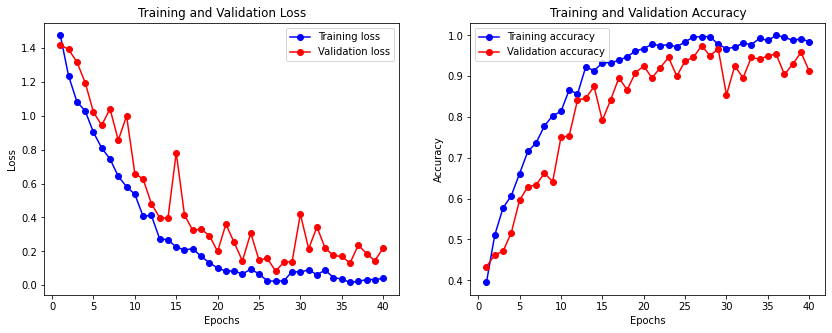

In [19]:
# 훈련 및 검증 이력 시각화
plot_training_history(train_loss_history, train_acc_history, val_loss_history, val_acc_history)